In [ ]:
"""
we using this shit
https://www.youtube.com/watch?v=VmbA0pi2cRQ
'it's gonna be mathaifemfaacal' fuk off

the point of this notebook is as follows:
given a function y(x) where we assume
y(x) = m*x + c + UNCORROLATED_RANDOM_NOISE

find m and c

also, we're doing all of this in cuda coz go fuck yourself I want this shit FAST

BONUS OBJECTIVE:
see if you can find the strength of the random noise, assuming that it's gaussian
"""

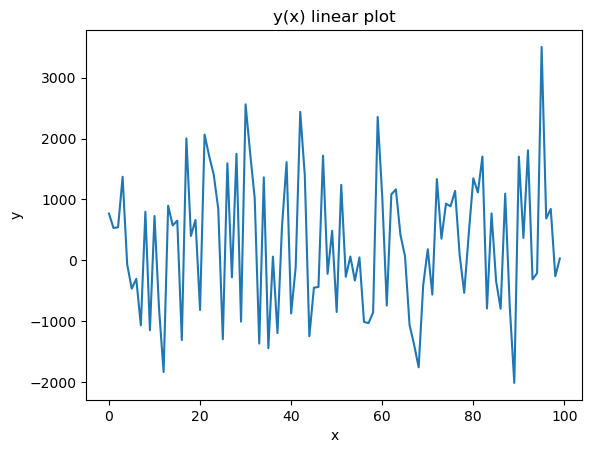

CudaAPIError: [700] Call to cuMemAlloc results in UNKNOWN_CUDA_ERROR

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import math
from numba import jit, cuda

BLOCKS_PER_GRID = 64
THREADS_PER_BLOCK = 64

M_INITIAL_GUESS = 0
C_INITIAL_GUESS = 0
MAX_ITERATIONS = 100
PRESENTAGE_BREAK = 10**-4
LEARNING_RATE = 1

# it returns [m, c]
def minimizeMeanSquaredError(x, y, printlog = True):
    m = M_INITIAL_GUESS
    c = C_INITIAL_GUESS
    lr = LEARNING_RATE
    step = 0
    while step < MAX_ITERATIONS:
        E = _getE(x, y, m, c)
        dEdm = _getdEdm(x, y, m, c)
        dEdc = _getdEdc(x, y, m, c)
        # the m part of the error grows quadratically with length and the c part grows linearly
        # so I included these len(x)**2 and len(x)**1 terms for that
        m -= lr * dEdm / float(len(x)**2)
        c -= lr * dEdc / float(len(x)**0.5)
        if printlog:
            print(f"step: {step}\tE: {E}\tm: {m}\tc: {c}")
        if 0 < step:
            if abs(E - prevE)/abs(E + prevE) < PRESENTAGE_BREAK:
                break
        prevE = E
        step += 1
    return [m, c]

# it returns [m, c, SD] where SD is the standard deviation of the gaussian noise
def minimizeMeanSquaredError2(x, y, printlog = True):
    return "TODO: implement this"

def _getE(x, y, m, c):
    if len(x) != len(y):
        raise Exception(f"len(x) = {len(x)} != len(y) = {len(y)}, make them equal")
    x_device = cuda.to_device(x)
    y_device = cuda.to_device(y)
    Earr_device = cuda.to_device(np.zeros(math.floor(len(y) / BLOCKS_PER_GRID)))
    _getE_kernel[BLOCKS_PER_GRID, THREADS_PER_BLOCK](x_device, y_device, Earr_device, m, c)
    cuda.synchronize()
    return sum(Earr_device.copy_to_host()) / float(len(x))

@cuda.jit
def _getE_kernel(x_device, y_device, Earr_device, m, c):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    for i in range(start, x_device.shape[0], stride):
        val = (y[i] - m*x[i] - c)**2
        cuda.atomic.add(Earr_device, math.floor(i / BLOCKS_PER_GRID), val)
    
def _getdEdm(x, y, m, c):
    if len(x) != len(y):
        raise Exception(f"len(x) = {len(x)} != len(y) = {len(y)}, make them equal")
    x_device = cuda.to_device(x)
    y_device = cuda.to_device(y)
    dEdmarr_device = cuda.to_device(np.zeros(math.floor(len(y) / BLOCKS_PER_GRID)))
    _getdEdm_kernel[BLOCKS_PER_GRID, THREADS_PER_BLOCK](x_device, y_device, dEdmarr_device, m, c)
    cuda.synchronize()
    return sum(dEdmarr_device.copy_to_host()) / float(len(x))
    
@cuda.jit
def _getdEdm_kernel(x_device, y_device, dEdmarr_device, m, c):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    for i in range(start, x_device.shape[0], stride):
        val = - (2 * x[i] * (y[i] - m*x[i] - c))
        cuda.atomic.add(dEdmarr_device, math.floor(i / BLOCKS_PER_GRID), val)
        
def _getdEdc(x, y, m, c):
    if len(x) != len(y):
        raise Exception(f"len(x) = {len(x)} != len(y) = {len(y)}, make them equal")
    x_device = cuda.to_device(x)
    y_device = cuda.to_device(y)
    dEdcarr_device = cuda.to_device(np.zeros(math.floor(len(y) / BLOCKS_PER_GRID)))
    _getdEdc_kernel[BLOCKS_PER_GRID, THREADS_PER_BLOCK](x_device, y_device, dEdcarr_device, m, c)
    cuda.synchronize()
    return sum(dEdcarr_device.copy_to_host()) / float(len(x))
    
@cuda.jit
def _getdEdc_kernel(x_device, y_device, dEdcarr_device, m, c):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    for i in range(start, x_device.shape[0], stride):
        val = - (2 * (y[i] - m*x[i] - c))
        cuda.atomic.add(dEdcarr_device, math.floor(i / BLOCKS_PER_GRID), val)
    
def plot(x, y):
    plt.title("y(x) linear plot") 
    plt.xlabel("x") 
    plt.ylabel("y") 
    plt.plot(x, y) 
    plt.show()

    
XMIN = 0
XMAX = 100
CORROLATION = 2
SHIFT = 100
NOISE_MU = 0
NOISE_SD = 1000
    
# make some crap linearly correlated data
x = np.zeros(XMAX - XMIN)
y = np.zeros(XMAX - XMIN)
for i in range(XMIN, XMAX):
    x[i] = i
    y[i] = (i * CORROLATION) + SHIFT + np.random.normal(NOISE_MU, NOISE_SD)
plot(x, y)
[m, c] = minimizeMeanSquaredError(x, y, True)
print(f"m:\t{m}\nc:\t{c}")
print(f"m should be\t{CORROLATION}\nc should be\t{SHIFT}")
print(f"m error\t{abs(CORROLATION - m)/abs(CORROLATION + m)}")
print(f"c error\t{abs(SHIFT - c)/abs(SHIFT + c)}")